In [133]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations
from scipy.stats import ttest_ind_from_stats, ttest_ind, shapiro, mannwhitneyu

## get positive and negative features
## -Number of features that describe the lesion (healthy vs group C)
# -How many of these are not affected, affected positively, and negatively by the treatment (group C vs group E) size effects?
# -How many features that treatment affects that are not pathologically related (Healthy vs  group E)
# -how many features representing the lesion are also shared in the other control group (C vs  B)   
# use CBE dataset as healthy

# the groups under evaluation will be B, C and E

# the control healthy group will be pre B,C and E

# now we need to compare this healthy group against C post (sick)

# The resulting features will be compared with the treated group (postE) so we can have the number and the magnitude of the effects of the treatment in the lesion specific features (possible no effect, positive effect and negative effect)

# then we compare healthy group vs the treated (postE) and we look at the features that are affected by the treatment but not part of the pathology (out of the resulting features of the previous step). we need to exclude from this the features that characterized the lesion state (healthy vs group C)

# csv of the ranking

In [134]:
## Directories and constants
FIGURES_DIR = './figures/Pain'
MODELS_DIR = './src/models'
DATA_DIR = '/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/csv/Pain_Plot_Features'
MEAN_FEATURES_FILE = './csv/Pain_hindlimb_mouse_features_2025-06-22_21-53-52.csv' # updated means and circular means
FORELIMB_MEANS_FILE = './csv/Pain_forelimb_mouse_features_2025-06-22_21-53-53.csv' # updated means and circular means
# MEAN_FEATURES_FILE = './csv/SCI_pre_acute_hindlimb_mouse_features_2025-06-06_15-11-59.csv'
# MEAN_FEATURES_FILE = './csv/sideview_hindlimb_mouse_features_new_H.csv'
HEALTHY_KEY = 'pre'
SICK_KEY = 'post'
CONTROL_KEY = 'C_'
SECONDARY_CONTROL_KEY = 'A_'
VIRUS_CONTROL_KEY = 'B_'
TREATMENT_CONTROL_KEY = 'E_'
SECONDARY_TREATMENT_KEY = 'D_'
SIDE_KEY = ('left','right')

In [175]:
## Treatments: E-D
## Controls: B-C

## C-B to check if virus is doing something or is it the lesion
## A should be similar to C

### Functions for statistical testing
def is_circular_feature(feature_name):
    fname = feature_name.lower()
    return (('angle' in fname or 'phase' in fname) and 'excursion' not in fname)

def circular_surrogate_test(values1_deg, values2_deg):
    """Approximate test for circular features using cosine and sine projections."""
    values1 = np.deg2rad(values1_deg)
    values2 = np.deg2rad(values2_deg)

    cos1, sin1 = np.cos(values1), np.sin(values1)
    cos2, sin2 = np.cos(values2), np.sin(values2)

    # Apply Welch's t-test to both projections
    _, p_cos = ttest_ind(cos1, cos2, equal_var=False)
    _, p_sin = ttest_ind(sin1, sin2, equal_var=False)

    return min(p_cos, p_sin)

def check_normality(values1, values2, alpha=0.05):
    """
    Returns True if both groups pass the Shapiro-Wilk normality test.
    """
    def is_valid_sample(values):
        return len(values) >= 3 and np.std(values) > 0

    if not is_valid_sample(values1) or not is_valid_sample(values2):
        return False

    p1 = shapiro(values1).pvalue
    p2 = shapiro(values2).pvalue
    return (p1 > alpha) and (p2 > alpha)

def nonparametric_test(values1, values2):
    """
    Mann-Whitney U test for two independent samples.
    Returns the p-value.
    """
    try:
        _, p = mannwhitneyu(values1, values2, alternative='two-sided')
        return p
    except Exception as e:
        print(f"   Mann-Whitney test failed: {e}")
        return np.nan

def compare_feature_distributions(df1, df2, label1='Group1', label2='Group2', alpha=0.05):
    """
    Compare all shared features between two datasets using Welch's t-test.

    Parameters:
        df1, df2: pandas.DataFrame
            DataFrames to compare. Must have 'Dataset', 'Mouse', and feature columns.
        label1, label2: str
            Labels for the groups being compared (used for output).
        alpha: float
            Significance level for Bonferroni correction.

    Returns:
        dict with summary and significant feature list
    """
    # Identify common features (exclude non-feature columns)
    non_feature_cols = {'Dataset', 'Mouse', 'Number of runs (#)', 'Number of steps (#)', 'Number of steps std'}
    shared_features = set(df1.columns) & set(df2.columns) - non_feature_cols
    shared_features = sorted(shared_features)  # for consistent ordering
    
    # Bonferroni correction
    corrected_alpha = alpha #/ len(shared_features)

    significant_features = []
    means = []
    for feature in shared_features:
        values1 = df1[feature].dropna().values
        values2 = df2[feature].dropna().values
        
        if len(values1) < 3 or len(values2) < 3:
            continue  # skip features with no data

        normal_ok = check_normality(values1, values2)

        mean1, std1, n1 = np.mean(values1), np.std(values1, ddof=1), len(values1)
        mean2, std2, n2 = np.mean(values2), np.std(values2, ddof=1), len(values2)

        ## Do circular statistics
        if is_circular_feature(feature):
            try:
                p_value = circular_surrogate_test(values1, values2)
            except Exception as e:
                print(f" - {feature}: circular test failed ({e})")
                continue
            label_suffix = " (circular approx)"
        else:
            if normal_ok:
                _, p_value = ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=n1,
                                            mean2=mean2, std2=std2, nobs2=n2,
                                            equal_var=False)
                label_suffix = ""
            else:
                p_value = nonparametric_test(values1, values2)
                label_suffix = " (nonparametric)"
        if p_value < corrected_alpha:
            if p_value < 0.001:
                star = '***'
            elif p_value < 0.01:
                star = '**'
            elif p_value < 0.05:
                star = '*'
            else:
                star = ''
            if is_circular_feature(feature):
                values1_rad = np.deg2rad(values1)
                values2_rad = np.deg2rad(values2)
                mean1_val = np.rad2deg(np.angle(np.mean(np.exp(1j * values1_rad))))
                mean2_val = np.rad2deg(np.angle(np.mean(np.exp(1j * values2_rad))))
                std1_val = np.rad2deg(np.sqrt(-2 * np.log(np.abs(np.mean(np.exp(1j * values1_rad))))))
                std2_val = np.rad2deg(np.sqrt(-2 * np.log(np.abs(np.mean(np.exp(1j * values2_rad))))))
                summary = f"{mean1_val:.1f}±{std1_val:.1f} vs {mean2_val:.1f}±{std2_val:.1f}°"
                mean1, mean2 = mean1_val, mean2_val
                std1, std2 = std1_val, std2_val
            elif normal_ok:
                summary = f"{mean1:.2f}±{std1:.2f} vs {mean2:.2f}±{std2:.2f}"
                mean1, mean2 = mean1, mean2
                std1, std2 = std1, std2
            else:
                med1, med2 = np.median(values1), np.median(values2)
                summary = f"{med1:.2f} (median) vs {med2:.2f} (median)"
                mean1, mean2 = med1, med2
                std1, std2 = np.std(values1, ddof=1), np.std(values2, ddof=1)
            significant_features.append((feature, star, label_suffix, summary))
            means.append((mean1, std1, mean2, std2))
            # print(f" - {feature}: p = {p_value:.4g} {star}")

    # Output summary
    # print(f"Comparison: {label1} vs {label2}")
    # print(f"{label1} sample size: {df1.shape[0]} mice")
    # print(f"{label2} sample size: {df2.shape[0]} mice")
    # print(f"Number of significantly different features: {len(significant_features)}")
    # print(f"Significant features: {sorted(significant_features)}")
    # print()

    return {
        'group1_label': label1,
        'group2_label': label2,
        'group1_n': df1.shape[0],
        'group2_n': df2.shape[0],
        'significant_features': significant_features,
        'n_significant': len(significant_features),
        'corrected_alpha': corrected_alpha,
        'means': means,
    }

def plot_significant_features(features_df, title, group1_df, group2_df, names, filename=None):
    means = features_df['means']
    features = features_df['significant_features']
    if not features:
        print("No significant features to plot.")
        return
    
    # Create subplot for each significant feature
    fig = make_subplots(rows=1, cols=len(features), 
                        subplot_titles=[f[0] for f in features])
    
    for i, (feature, star, label_suffix, summary) in enumerate(features):
        # Get data for this feature from both groups
        values1 = group1_df[feature].dropna()
        values2 = group2_df[feature].dropna()
        
        mean_1 = means[i][0]
        std_1 = means[i][1]
        mean_2 = means[i][2]
        std_2 = means[i][3]

        # Create grouped bar chart
        fig.add_trace(
            go.Bar(
                x=names,
                y=[mean_1, mean_2],
                error_y=dict(
                    type='data',
                    array=[std_1, std_2],
                    visible=True
                ),
                name=feature,
                text=[f"{mean_1:.2f}±{std_1:.2f}", 
                      f"{mean_2:.2f}±{std_2:.2f}"],
                textposition='auto',
                hoverinfo='text',
                hovertext=summary + f" {star}"
            ),
            row=1, col=i+1
        )
    
        # Add point distribution (scatter) with jitter
        jitter_strength = 0.1
        x1 = [0 - jitter_strength + np.random.rand() * 2 * jitter_strength for _ in values1]
        x2 = [1 - jitter_strength + np.random.rand() * 2 * jitter_strength for _ in values2]

        fig.add_trace(
            go.Scatter(
                x=[names[0]] * len(values1),
                y=values1,
                mode='markers',
                marker=dict(size=6, opacity=0.5, color='black'),
                name='Group 1',
                showlegend=False
            ),
            row=1, col=i+1
        )

        fig.add_trace(
            go.Scatter(
                x=[names[1]] * len(values2),
                y=values2,
                mode='markers',
                marker=dict(size=6, opacity=0.5, color='black'),
                name='Group 2',
                showlegend=False
            ),
            row=1, col=i+1
        )

    fig.update_layout(
        title=title,
        showlegend=False,
        height=400,
        width=500 * len(features)
    )
    
    if filename:
        fig.write_image(os.path.join(FIGURES_DIR, filename))
    fig.show()

def plot_feature_across_groups(feature_subsets,feature_key, limb='hindlimb', max_cols=4, groups = ['A_', 'B_', 'C_', 'D_', 'E_'], state = ['healthy', 'sick'], sides = ['left', 'right']):
    """
    Plot a feature (or group of features) across all group subsets for a given limb.
    """
    data_subsets = feature_subsets[limb]
    matched_features = [col for col in next(iter(data_subsets.values())).columns if feature_key in col.lower() and 'std' not in col.lower()]

    if not matched_features:
        print(f"No features matching '{feature_key}' found in {limb} data.")
        return

    num_features = len(matched_features)
    rows = (num_features + max_cols - 1) // max_cols
    cols = min(num_features, max_cols)

    # palette
    palette = px.colors.qualitative.Plotly  
    num_features = len(matched_features)
    rows = (num_features + max_cols - 1) // max_cols
    cols = min(num_features, max_cols)

    subplot_titles = [
        col.replace('Mean', '').replace('- rhindlimb - ', '').strip()
        for col in matched_features
    ]

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

    for idx, feature in enumerate(matched_features):
        row = idx // max_cols + 1
        col = idx % max_cols + 1

        group_means = []
        group_stds = []
        group_names = []
        group_points = []

        for name, df in data_subsets.items():
            if feature not in df.columns: continue # skip if feature not in df
            if not any(side in name.lower() for side in sides): continue  # skip if side not in name

            values = df[feature].dropna()
            if len(values) == 0:
                continue

            if any(g in name for g in groups) and any(s in name for s in state):
                group_means.append(values.mean())
                group_stds.append(values.std())
                group_names.append(name)
                group_points.append(values)

        if not group_names:
            continue

        # build a color list the same length as group_names
        bar_colors = [palette[i % len(palette)] for i in range(len(group_names))]
        
        # Bar trace with error bars
        fig.add_trace(
            go.Bar(
                x=group_names,
                y=group_means,
                error_y=dict(type='data', array=group_stds, visible=True),
                name=feature,
                # text=[f"{m:.2f}±{s:.2f}" for m, s in zip(group_means, group_stds)],
                textposition='auto',
                marker=dict(
                    color=bar_colors,            # fill colors per bar
                    line=dict(
                        color='black',            # uniform border color
                        width=1                   # border width in pixels
                    )
                )
            ),
            row=row, col=col
        )

        # Scatter plot for individual points
        for i, (group, values) in enumerate(zip(group_names, group_points)):
            x_vals = [group] * len(values)
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=values,
                    mode='markers',
                    marker=dict(size=6, opacity=0.5, color='black'),
                    showlegend=False
                ),
                row=row, col=col
            )

    fig.update_layout(
        title=f"Feature(s) Matching '{feature_key}' in {limb}",
        showlegend=False,
        height=500 * rows,
        width=300 * cols,
        # remove background color
        plot_bgcolor='rgba(0,0,0,0)',
    )

    return fig

In [136]:
# Example inputs: update as needed
experimental_groups = ['A', 'B', 'C', 'D', 'E']
sides = {'left': SIDE_KEY[0].lower(), 'right': SIDE_KEY[1].lower()}
health_statuses = {'healthy': HEALTHY_KEY.lower(), 'sick': SICK_KEY.lower()}
run_types = {
    'A': SECONDARY_CONTROL_KEY.lower(),
    'B': VIRUS_CONTROL_KEY.lower(),
    'C': CONTROL_KEY.lower(),
    'D': SECONDARY_TREATMENT_KEY.lower(),
    'E': TREATMENT_CONTROL_KEY.lower()
}

# Load data
hindlimb_features_df = pd.read_csv(MEAN_FEATURES_FILE)
forelimb_features_df = pd.read_csv(FORELIMB_MEANS_FILE) 

# filter std columns
hindlimb_features_df = hindlimb_features_df.loc[:, ~hindlimb_features_df.columns.str.contains('std')]
forelimb_features_df = forelimb_features_df.loc[:, ~forelimb_features_df.columns.str.contains('std')]

# filter columns without 'step' or 'hindlimb'
cols = hindlimb_features_df.columns
hindlimb_mask = cols.str.lower().str.contains('hindlimb', case=False)
step_mask = cols.str.lower().str.contains('step', case=False) & ~cols.str.contains('/s', case=False)
limb_mask = cols.str.lower().str.contains('hindpaw|hindfinger|knee|ankle|hip', case=False)
meta_mask = cols.str.lower().str.contains('dataset|mouse', case=False)
final_mask = hindlimb_mask | step_mask | meta_mask | limb_mask

hindlimb_features_df = hindlimb_features_df.loc[:, final_mask]
forelimb_features_df = forelimb_features_df.loc[:, final_mask]

# Container for all feature subsets
feature_subsets = {
    'hindlimb': {},
    'forelimb': {}
}

# General function for filtering
def filter_features(df, health_key, run_key, side_key):
    return df[
        df['Dataset'].str.lower().str.contains(health_key) &
        df['Dataset'].str.lower().str.contains(run_key) &
        df['Mouse'].str.lower().str.contains(side_key)
    ]

# Generate subsets
for run_code in experimental_groups:
    run_key = run_types.get(run_code)
    if not run_key:
        continue  # skip undefined keys

    for health_label, health_key in health_statuses.items():
        for side_label, side_key in sides.items():
            name = f"{health_label}_{side_label}_{run_code}_run"

            feature_subsets['hindlimb'][name] = filter_features(hindlimb_features_df, health_key, run_key, side_key)
            feature_subsets['forelimb'][name] = filter_features(forelimb_features_df, health_key, run_key, side_key)

# Example usage
print(f"Number of hindlimb features: {hindlimb_features_df.shape[1]-3}")
print(f"Number of forelimb features: {forelimb_features_df.shape[1]-3}")

# Access a subset:
# feature_subsets['hindlimb']['healthy_left_c_run']

Number of hindlimb features: 382
Number of forelimb features: 382


In [137]:
# Create all valid combinations of health status, run, and side
group_defs = [
    (health_label, run_code, side_label)
    for health_label in ['healthy', 'sick']
    for run_code in experimental_groups
    for side_label in ['left', 'right']
]

# Store results
comparison_results = {
    'hindlimb': [],
    'forelimb': []
}

print(len(list(combinations(group_defs, 2))), "combinations to compare")
print(f"Groups: {len(group_defs)} - group items: {group_defs}") # nbr = comb(20, 2) = 190

190 combinations to compare
Groups: 20 - group items: [('healthy', 'A', 'left'), ('healthy', 'A', 'right'), ('healthy', 'B', 'left'), ('healthy', 'B', 'right'), ('healthy', 'C', 'left'), ('healthy', 'C', 'right'), ('healthy', 'D', 'left'), ('healthy', 'D', 'right'), ('healthy', 'E', 'left'), ('healthy', 'E', 'right'), ('sick', 'A', 'left'), ('sick', 'A', 'right'), ('sick', 'B', 'left'), ('sick', 'B', 'right'), ('sick', 'C', 'left'), ('sick', 'C', 'right'), ('sick', 'D', 'left'), ('sick', 'D', 'right'), ('sick', 'E', 'left'), ('sick', 'E', 'right')]


In [138]:
to_compare = [['A_', 'C_', 'B_', 'E_'], ['C_','E_'], ['A_','C_'], ['B_','C_']]
bp_list = ['angle value', 'phase value']

for groups in to_compare:
    for bp in bp_list:
        fig = plot_feature_across_groups(feature_subsets=feature_subsets, feature_key=bp, limb='hindlimb', sides=['left'], groups=groups, state=['sick'])
        group_name = [f"{g.replace('_', '')}" for g in groups]
        # fig.write_image(os.path.join('./', f'hind_L_{str(group_name).replace("'", "").replace(", ", "").replace("[", "").replace("]", "_")}{bp}.png'))
# color code the plots
# plot c and a
# ankle good for effect of injury
# look for hindpaw features to show (finger, paw, ankle) - > filter to only ankle and paw differences
# all left: C vs E, A vs C, B vs C (post) -> one single plot of left limb
# try t-test without bonferroni (test)

In [139]:
# Compare each pair of groups (no repeats)
for (health1, run1, side1), (health2, run2, side2) in combinations(group_defs, 2):
    if side1 != side2 and run1 != run2:
        continue  # Do not compare different sides of different groups

    for limb_type in ['hindlimb', 'forelimb']:
        key1 = f"{health1}_{side1}_{run1}_run"
        key2 = f"{health2}_{side2}_{run2}_run"

        df1 = feature_subsets[limb_type].get(key1)
        df2 = feature_subsets[limb_type].get(key2)

        if df1 is None or df2 is None or df1.empty or df2.empty:
            continue

        label1 = f"{limb_type.title()} {health1.title()} {side1.title()} {run1.upper()}"
        label2 = f"{limb_type.title()} {health2.title()} {side2.title()} {run2.upper()}"

        result = compare_feature_distributions(df1, df2, label1=label1, label2=label2)
        comparison_results[limb_type].append(((key1, key2), result))

        title = f"{label1} vs {label2}"
        # plot_significant_features(result, title=title, group1_df=df1, group2_df=df2, names=[label1, label2])

## Add a entry in comparison_results for all sick left (except D and E) vs E sick left
key_1 = 'sick_left_ALL_run'
key_2 = 'sick_left_E_run'
df12 = feature_subsets['hindlimb']['sick_left_B_run']
df13 = feature_subsets['hindlimb']['sick_left_C_run']
df1 = pd.concat([df12, df13], ignore_index=True)
df2 = feature_subsets['hindlimb']['sick_left_E_run']
label1 = 'Hindlimb Sick Left B, C'
label2 = 'Hindlimb Sick Left E'

result = compare_feature_distributions(df1, df2, label1=label1, label2=label2)
comparison_results['hindlimb'].append(((key_1, key_2), result))

## lesion effect
key_1 = 'healthy_left_ALL_run'
key_2 = 'sick_left_C_run'
df11 = feature_subsets['hindlimb']['healthy_left_C_run']
df12 = feature_subsets['hindlimb']['healthy_left_B_run']
df13 = feature_subsets['hindlimb']['healthy_left_E_run']
df1 = pd.concat([df11, df12, df13], ignore_index=True)
df2 = feature_subsets['hindlimb']['sick_left_C_run']
label1 = 'Hindlimb Healthy Left B, C, E'
label2 = 'Hindlimb Sick Left C'

result = compare_feature_distributions(df1, df2, label1=label1, label2=label2)
comparison_results['hindlimb'].append(((key_1, key_2), result))

## healthy vs E
key_1 = 'healthy_left_ALL_run'
key_2 = 'sick_left_E_run'
df11 = feature_subsets['hindlimb']['healthy_left_C_run']
df12 = feature_subsets['hindlimb']['healthy_left_B_run']
df13 = feature_subsets['hindlimb']['healthy_left_E_run']
df1 = pd.concat([df11, df12, df13], ignore_index=True)
df2 = feature_subsets['hindlimb']['sick_left_E_run']
label1 = 'Hindlimb Healthy Left B, C, E'
label2 = 'Hindlimb Sick Left E'

result = compare_feature_distributions(df1, df2, label1=label1, label2=label2)
comparison_results['hindlimb'].append(((key_1, key_2), result))

In [140]:
def _to_name_set(result):
    names = []
    for item in result:
        # accept 'feature' or ('feature', ...), clean whitespace
        name = item[0] if isinstance(item, (list, tuple)) else item
        name = ' '.join(str(name).split())  # collapse weird spacing
        names.append(name)
    return set(names)

def intersect_significant_features(*results):
    """
    Each result is a list of strings or tuples; intersect by the feature name (first element).
    """
    sets = [_to_name_set(r) for r in results]
    return set.intersection(*sets) if sets else set()

def exclude_intersection_features(*results):
    """
    Return features unique to each result (by name only).
    """
    sets = [_to_name_set(r) for r in results]
    if not sets:
        return []
    inter = set.intersection(*sets)
    return [s - inter for s in sets]

def globally_unique_features(*results):
    from collections import Counter
    """
    Return features that appear in exactly one result across all results.
    """
    sets = [_to_name_set(r) for r in results]
    all_features = [feat for s in sets for feat in s]
    counts = Counter(all_features)
    return {feat for feat, count in counts.items() if count == 1}

In [141]:
limb = 'hindlimb'  # or 'forelimb'
data = comparison_results[limb]

print(f"\nComparison results for {limb}:")
for (key1, key2), result in data:
    if ('ALL' in key1 and 'C_' in key2) and ('healthy' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        print(f"Comparison {key1} vs {key2}:")
        print(f"\tNumber of significant features: {result['n_significant']}")
        features_ac = [f for f in result['significant_features']]
        print(f"\tSignificant features: {features_ac}")
        # plot_significant_features(result, title=f"{key1} vs {key2}", group1_df=feature_subsets[limb].get(key1), group2_df=feature_subsets[limb].get(key2), names=[key1, key2])
        print("-" * 40)

rows = []

for (key1, key2), result in comparison_results[limb]:
    if ('ALL' in key1 and 'C_' in key2) and ('healthy' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        for feat_tuple in result['significant_features']:
            # feat_tuple looks like: (feature_name, '*', '(circular approx)', 'values...')
            feature_name = feat_tuple[0]
            values_str = feat_tuple[-1]  # last element is the values string

            values_split = values_str.split(' vs ')

            rows.append((feature_name, values_split[0], values_split[1]))

# Create DataFrame
all_vs_c_df = pd.DataFrame(rows, columns=["feature", "value 1", "value 2"])

# Save to CSV
# all_vs_c_df.to_csv("c_healthy_sick.csv", index=False)


Comparison results for hindlimb:
Comparison healthy_left_ALL_run vs sick_left_C_run:
	Number of significant features: 103
	Significant features: [('Mean angle acceleration - rhindlimb - ankle (rad/s^2)', '*', ' (circular approx)', '-92.0±22.4 vs -86.6±13.9°'), ('Mean angle acceleration during swing - rhindlimb - hip (rad/s^2)', '*', ' (circular approx)', '0.1±1.1 vs -0.7±0.9°'), ('Mean angle at peak - rhindlimb - ankle (°)', '***', ' (circular approx)', '66.8±11.0 vs 57.6±4.4°'), ('Mean angle at peak - rhindlimb - knee (°)', '**', ' (circular approx)', '89.8±2.6 vs 86.6±2.6°'), ('Mean angle at peak - rhindlimb - lHindfingers (°)', '**', ' (circular approx)', '126.0±17.7 vs 144.3±12.8°'), ('Mean angle at peak - rhindlimb - lHindpaw (°)', '**', ' (circular approx)', '162.3±5.5 vs 156.9±3.6°'), ('Mean angle at stance - rhindlimb - hip (°)', '***', ' (circular approx)', '127.4±2.9 vs 123.8±2.1°'), ('Mean angle at stance - rhindlimb - lHindfingers (°)', '**', ' (circular approx)', '175.8±1

In [142]:
print(f"\nComparison results for {limb}:")
for (key1, key2), result in data:
    if ('ALL' in key1 and 'E_' in key2) and ('healthy' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        print(f"Comparison {key1} vs {key2}:")
        print(f"\tNumber of significant features: {result['n_significant']}")
        features_ac = [f for f in result['significant_features']]
        print(f"\tSignificant features: {features_ac}")
        # plot_significant_features(result, title=f"{key1} vs {key2}", group1_df=feature_subsets[limb].get(key1), group2_df=feature_subsets[limb].get(key2), names=[key1, key2])
        print("-" * 40)

rows = []

for (key1, key2), result in comparison_results[limb]:
    if ('ALL' in key1 and 'E_' in key2) and ('healthy' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        for feat_tuple in result['significant_features']:
            # feat_tuple looks like: (feature_name, '*', '(circular approx)', 'values...')
            feature_name = feat_tuple[0]
            values_str = feat_tuple[-1]  # last element is the values string

            values_split = values_str.split(' vs ')

            rows.append((feature_name, values_split[0], values_split[1]))

# Create DataFrame
all_vs_e_df = pd.DataFrame(rows, columns=["feature", "value 1", "value 2"])

# Save to CSV
all_vs_e_df.to_csv("all_healthy_vs_e_sick.csv", index=False)


Comparison results for hindlimb:
Comparison healthy_left_ALL_run vs sick_left_E_run:
	Number of significant features: 129
	Significant features: [('Mean angle acceleration - rhindlimb - ankle (rad/s^2)', '*', ' (circular approx)', '-92.0±22.4 vs -77.6±10.6°'), ('Mean angle acceleration - rhindlimb - hip (rad/s^2)', '*', ' (circular approx)', '-141.5±30.4 vs -127.9±14.5°'), ('Mean angle acceleration - rhindlimb - knee (rad/s^2)', '**', ' (circular approx)', '-128.2±25.8 vs -112.4±13.0°'), ('Mean angle acceleration - rhindlimb - lHindfingers (rad/s^2)', '**', ' (circular approx)', '147.1±45.7 vs 164.9±18.7°'), ('Mean angle acceleration - rhindlimb - lHindpaw (rad/s^2)', '**', ' (circular approx)', '146.8±42.9 vs 175.2±23.7°'), ('Mean angle acceleration at swing - rhindlimb - ankle (rad/s^2)', '*', ' (circular approx)', '-3.5±111.2 vs -111.0±61.1°'), ('Mean angle acceleration during stance - rhindlimb - knee (rad/s^2)', '*', ' (circular approx)', '0.3±1.2 vs 0.4±0.8°'), ('Mean angle acce

In [143]:
limb = 'hindlimb'  # or 'forelimb'
data = comparison_results[limb]

print(f"\nComparison results for {limb}:")
for (key1, key2), result in data:
    if ('A_' in key1 and 'C_' in key2) and ('sick' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        print(f"Comparison {key1} vs {key2}:")
        print(f"\tNumber of significant features: {result['n_significant']}")
        features_ac = [f for f in result['significant_features']]
        print(f"\tSignificant features: {features_ac}")
        # plot_significant_features(result, title=f"{key1} vs {key2}", group1_df=feature_subsets[limb].get(key1), group2_df=feature_subsets[limb].get(key2), names=[key1, key2])
        print("-" * 40)


Comparison results for hindlimb:
Comparison sick_left_A_run vs sick_left_C_run:
	Number of significant features: 16
	Significant features: [('Mean angle acceleration during swing - rhindlimb - hip (rad/s^2)', '*', ' (circular approx)', '0.5±0.9 vs -0.7±0.9°'), ('Mean angle acceleration during swing - rhindlimb - lHindfingers (rad/s^2)', '*', ' (circular approx)', '0.2±0.7 vs 0.1±1.2°'), ('Mean angle during stance - rhindlimb - knee (°)', '*', ' (circular approx)', '1.6±0.1 vs 1.6±0.0°'), ('Mean angle during swing - rhindlimb - ankle (°)', '**', ' (circular approx)', '1.0±0.1 vs 1.1±0.0°'), ('Mean angle excursion - rhindlimb - lHindpaw (°)', '**', '', '57.51±1.89 vs 60.39±2.19'), ('Mean angle value - rhindlimb - lHindpaw (°)', '*', ' (circular approx)', '149.3±2.9 vs 146.9±1.8°'), ('Mean angle velocity - rhindlimb - lHindpaw (rad/s)', '*', ' (circular approx)', '0.0±0.1 vs 0.1±0.1°'), ('Mean angle velocity at peak - rhindlimb - lHindpaw (rad/s)', '*', ' (circular approx)', '2.9±2.9 vs 

In [144]:
data = comparison_results[limb]
    
print(f"\nComparison results for {limb}:")
for (key1, key2), result in data:
    if ('B_' in key1 and 'C_' in key2) and ('sick' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        print(f"Comparison {key1} vs {key2}:")
        print(f"\tNumber of significant features: {result['n_significant']}")
        features_bc = [f for f in result['significant_features']]
        print(f"\tSignificant features: {features_bc}") # Only print feature names
        # plot_significant_features(result, title=f"{key1} vs {key2}", group1_df=feature_subsets[limb].get(key1), group2_df=feature_subsets[limb].get(key2), names=[key1, key2])
        print("-" * 40)


Comparison results for hindlimb:
Comparison sick_left_B_run vs sick_left_C_run:
	Number of significant features: 25
	Significant features: [('Mean angle acceleration - rhindlimb - ankle (rad/s^2)', '*', ' (circular approx)', '-110.1±22.0 vs -86.6±13.9°'), ('Mean angle acceleration - rhindlimb - knee (rad/s^2)', '*', ' (circular approx)', '-147.0±24.8 vs -124.1±18.9°'), ('Mean angle acceleration at peak - rhindlimb - lHindpaw (rad/s^2)', '*', ' (circular approx)', '-165.5±64.3 vs -11.0±100.5°'), ('Mean angle during stance - rhindlimb - knee (°)', '*', ' (circular approx)', '1.6±0.0 vs 1.6±0.0°'), ('Mean angle velocity at peak - rhindlimb - lHindpaw (rad/s)', '*', ' (circular approx)', '0.8±3.1 vs 2.0±7.5°'), ('Mean angle velocity during swing - rhindlimb - lHindpaw (rad/s)', '*', ' (circular approx)', '0.1±0.5 vs 0.5±1.4°'), ('Mean phase acceleration at swing - rhindlimb - knee (rad/s^2)', '*', ' (circular approx)', '-81.5±64.0 vs 87.2±85.2°'), ('Mean phase velocity at stance - rhindli

In [145]:
data = comparison_results[limb]
    
print(f"\nComparison results for {limb}:")
## print the data for C vs E
for (key1, key2), result in data:
    if 'C_' in key1 and 'E_' in key2 and ('sick' in key1 and 'sick' in key2) and ('left' in key1 and 'left' in key2):
        print(f"Comparison {key1} vs {key2}:")
        print(f"\tNumber of significant features: {result['n_significant']}")
        features_ce = [f for f in result['significant_features']]
        print(f"\tSignificant features: {features_ce}")  # Only print feature names with 'hindlimb' or 'step' but not 'm/s'
        # plot_significant_features(result, title=f"{key1} vs {key2}", group1_df=feature_subsets[limb].get(key1), group2_df=feature_subsets[limb].get(key2), names=[key1, key2])
        print("-" * 40)


Comparison results for hindlimb:
Comparison sick_left_C_run vs sick_left_E_run:
	Number of significant features: 50
	Significant features: [('Mean angle acceleration at peak - rhindlimb - ankle (rad/s^2)', '*', ' (circular approx)', '-144.9±66.6 vs -20.1±86.3°'), ('Mean angle acceleration at peak - rhindlimb - lHindfingers (rad/s^2)', '*', ' (circular approx)', '-128.9±70.2 vs 65.5±86.2°'), ('Mean angle acceleration during swing - rhindlimb - hip (rad/s^2)', '*', ' (circular approx)', '-0.7±0.9 vs 0.4±1.3°'), ('Mean angle at stance - rhindlimb - lHindpaw (°)', '***', ' (circular approx)', '146.0±3.4 vs 151.3±1.8°'), ('Mean angle at touchdown - rhindlimb - hip (°)', '*', ' (circular approx)', '127.8±2.0 vs 130.3±2.0°'), ('Mean angle at touchdown - rhindlimb - lHindpaw (°)', '**', ' (circular approx)', '148.9±4.2 vs 154.7±2.5°'), ('Mean angle during stance - rhindlimb - ankle (°)', '*', ' (circular approx)', '1.2±0.1 vs 1.2±0.0°'), ('Mean angle during stance - rhindlimb - hip (°)', '*',

In [146]:
feature_intersections = intersect_significant_features(features_ac, features_bc, features_ce)
feature_intersections_ac_ce = intersect_significant_features(features_ac, features_ce)
feature_intersections_bc_ce = intersect_significant_features(features_bc, features_ce)
feature_exclusions = exclude_intersection_features(features_ac, features_bc, features_ce)
global_unique = globally_unique_features(features_ac, features_bc, features_ce)

print("\nIntersection of significant features across comparisons:")
print(f"Total features in intersection: {len(feature_intersections)}")
print(f"Features: {sorted(feature_intersections)}")
print("-" * 40)

print("Intersection of significant features for A vs C and C vs E:")
print(f"Total features in intersection: {len(feature_intersections_ac_ce)}")
print(f"Features: {sorted(feature_intersections_ac_ce)}")
print("-" * 40)

print("Intersection of significant features for B vs C and C vs E:")
print(f"Total features in intersection: {len(feature_intersections_bc_ce)}")
print(f"Features: {sorted(feature_intersections_bc_ce)}")
print("-" * 40)

print("\nUnique significant features for each comparison:")
print("Number of unique features in A vs C:", len(feature_exclusions[0]))
print("A vs C unique features:", sorted(feature_exclusions[0]))
print("-" *40)
print("Number of unique features in B vs C:", len(feature_exclusions[1]))
print("B vs C unique features:", sorted(feature_exclusions[1]))
print("-" *40)
print("Number of unique features in C vs E:", len(feature_exclusions[2]))
print("C vs E unique features:", sorted(feature_exclusions[2]))
print("-" *40)

print("Globally unique features across all comparisons:")
print(f"Total globally unique features: {len(global_unique)}")
print(f"Globally unique features: {sorted(global_unique)}")


Intersection of significant features across comparisons:
Total features in intersection: 0
Features: []
----------------------------------------
Intersection of significant features for A vs C and C vs E:
Total features in intersection: 6
Features: ['Mean angle acceleration during swing - rhindlimb - hip (rad/s^2)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean angle value - rhindlimb - lHindpaw (°)', 'Mean phase acceleration during swing - rhindlimb - hip (rad/s^2)', 'Mean phase during swing - rhindlimb - ankle (°)', 'Mean step acceleration Y at touchdown - ankle (m/s^2)']
----------------------------------------
Intersection of significant features for B vs C and C vs E:
Total features in intersection: 4
Features: ['Mean step velocity X during swing - hip (m/s)', 'Mean step velocity X during swing - knee (m/s)', 'Mean step velocity X during swing - lHindfingers (m/s)', 'Mean step velocity X during swing - lHindpaw (m/s)']
----------------------------------------

Unique s

In [147]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

def preprocess_data(df: pd.DataFrame):
    data = df.copy()

    label_encoder_dataset = LabelEncoder()
    label_encoder_mouse = LabelEncoder()

    data["Dataset_Encoded"] = label_encoder_dataset.fit_transform(data["Dataset"])
    data["Mouse_Encoded"] = label_encoder_mouse.fit_transform(data["Mouse"])

    dataset_label_map = dict(zip(data["Dataset_Encoded"], data["Dataset"]))
    mouse_label_map = dict(zip(data["Mouse_Encoded"], data["Mouse"]))
    label_cols = ["Dataset_Encoded", "Mouse_Encoded"]

    data = data.drop(columns=["Dataset", "Mouse"])
    features = [col for col in data.columns if col not in label_cols]

    ## Convert angle features to radians if they contain '°'
    angular_features = [f for f in features if ('angle' in f.lower() or 'phase' in f.lower())
                        and 'excursion' not in f.lower()
                        and not f.lower().endswith('_sin')
                        and not f.lower().endswith('_cos')]
    for feature in angular_features:
        if '°' in feature:
            data[feature] = np.deg2rad(data[feature])

    ## Linearize angular features
    trig_features = {
        f"{feature}_cos": np.cos(data[feature]) for feature in angular_features
    }
    trig_features.update({
        f"{feature}_sin": np.sin(data[feature]) for feature in angular_features
    })
    trig_df = pd.DataFrame(trig_features, index=data.index)    
    data = pd.concat([data.drop(columns=angular_features), trig_df], axis=1)
    features = [col for col in data.columns if col not in label_cols]   

    ## Scale features
    scaler = StandardScaler()#RobustScaler()
    X_scaled = scaler.fit_transform(data[features])
    y = data[label_cols].values

    df_preprocessed = pd.DataFrame(X_scaled, columns=features)
    df_preprocessed[label_cols] = y

    print("[DEBUG] Dataset Label Map:", dataset_label_map)
    print("[DEBUG] Mouse Label Map:", mouse_label_map)

    return df_preprocessed, dataset_label_map, mouse_label_map, label_cols

In [148]:
from src.pain_analysis import perform_dimensionality_reduction, aggregate_features

left_hindlimb_features_df = hindlimb_features_df[hindlimb_features_df['Mouse'].str.lower().str.contains('left')]
left_hindlimb_features_df = left_hindlimb_features_df.drop(columns=['Number of steps (#)'])
preprocessed_data, dataset_label_map, mouse_label_map, label_cols = preprocess_data(left_hindlimb_features_df)

X_agg, y_mouse, y_dataset = aggregate_features(preprocessed_data, label_cols, method="median")

umap_reducer, umap_plot_df = perform_dimensionality_reduction(
        X_agg, y_mouse, y_dataset,
        dataset_label_map, mouse_label_map,
        method="UMAP", n_components=3,
        target_metric='categorical',
        target_weight=0,
        n_neighbors=15,
        min_dist=0.05,
        plot=False, save=False
    )

[DEBUG] Dataset Label Map: {0: 'A_postDLC', 1: 'A_preDLC', 2: 'B_postDLC', 3: 'B_preDLC', 4: 'C_postDLC', 5: 'C_preDLC', 6: 'D_postDLC', 7: 'D_preDLC', 8: 'E_postDLC', 9: 'E_preDLC'}
[DEBUG] Mouse Label Map: {10: 'mouse1_left', 21: 'mouse2_left', 32: 'mouse3_left', 43: 'mouse4_left', 45: 'mouse5_left', 46: 'mouse6_left', 47: 'mouse7_left', 48: 'mouse8_left', 49: 'mouse9_left', 0: 'mouse10_left', 1: 'mouse11_left', 2: 'mouse12_left', 3: 'mouse13_left', 4: 'mouse14_left', 5: 'mouse15_left', 6: 'mouse16_left', 7: 'mouse17_left', 8: 'mouse18_left', 9: 'mouse19_left', 11: 'mouse20_left', 12: 'mouse21_left', 13: 'mouse22_left', 14: 'mouse23_left', 15: 'mouse24_left', 16: 'mouse25_left', 17: 'mouse26_left', 18: 'mouse27_left', 19: 'mouse28_left', 20: 'mouse29_left', 22: 'mouse30_left', 23: 'mouse31_left', 24: 'mouse32_left', 25: 'mouse33_left', 26: 'mouse34_left', 27: 'mouse35_left', 28: 'mouse36_left', 29: 'mouse37_left', 30: 'mouse38_left', 31: 'mouse39_left', 33: 'mouse40_left', 35: 'mouse

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [149]:
### Plotting UMAP in 3D -> 573 features total
umap_plot_df["DatasetName"] = umap_plot_df["Dataset"].map(dataset_label_map)
umap_plot_df["MouseName"]   = umap_plot_df["Mouse"].map(mouse_label_map)

# --- Build a consistent color map ---
fixed_color = "#7f7f7f"  # gray for Pre
all_names = sorted(umap_plot_df["DatasetName"].unique())

# Non-Pre datasets get distinct colors from a qualitative palette
palette = px.colors.qualitative.Plotly  # or px.colors.qualitative.Set3, etc.
non_pre = [n for n in all_names if "pre" not in n.lower()]

color_map = {"Pre": fixed_color}
color_map.update({name: palette[i % len(palette)] for i, name in enumerate(non_pre)})

# Color key: collapse anything containing "pre" to "Pre", keep others as-is
umap_plot_df["ColorKey"] = umap_plot_df["DatasetName"].apply(
    lambda x: "Pre" if "pre" in x.lower() else x
)

# --- Build the two px figures using the SAME color map ---
fig_left = px.scatter_3d(
    umap_plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="ColorKey",
    hover_name="MouseName",
    hover_data={"Dataset": True, "Mouse": True},
    title="UMAP 3D — Pre vs Others",
    color_discrete_map=color_map
)
fig_left.update_traces(marker=dict(size=4, line=dict(width=0.3, color='black')),
                       selector=dict(mode='markers'))

fig_right = px.scatter_3d(
    umap_plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="DatasetName",
    hover_name="MouseName",
    hover_data={"Dataset": True, "Mouse": True},
    title="UMAP 3D — Each Dataset",
    color_discrete_map=color_map
)
fig_right.update_traces(marker=dict(size=4, line=dict(width=0.3, color='black')),
                        selector=dict(mode='markers'))

# --- Put them side by side with shared legend ---
combo = make_subplots(rows=1, cols=2,
                      specs=[[{"type": "scene"}, {"type": "scene"}]],
                      subplot_titles=(fig_left.layout.title.text, fig_right.layout.title.text))

for tr in fig_left.data:
    combo.add_trace(tr, row=1, col=1)
for tr in fig_right.data:
    combo.add_trace(tr, row=1, col=2)

# Layout tweaks: one legend, equal aspect, tidy margins
combo.update_layout(
    showlegend=True,
    legend=dict(title="Dataset", orientation="v"),
    scene=dict(aspectmode="data"),
    scene2=dict(aspectmode="data"),
    margin=dict(l=0, r=0, t=60, b=0),
    height=600, width=1100
)

combo.show()

# plot on right where A, B and C are of the same color (orange)
# green for E post
# cyan for Pre healthy
# delete D

## 1 plot with all, 1 without D, 1 with controls fused by color (post)
## Find features that cluster controls post and all pre states
## Try to use significant features to plot the UMAP

# TODO:
# 1 comparison between sicks and treated: how many features are different?
# 2 How many of the different ones are going towards the healthy?
# 3 How many of the features are moving away from the healthy state?

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/src/pain_analysis.py:237: UserWarning:

The figure layout has changed to tight



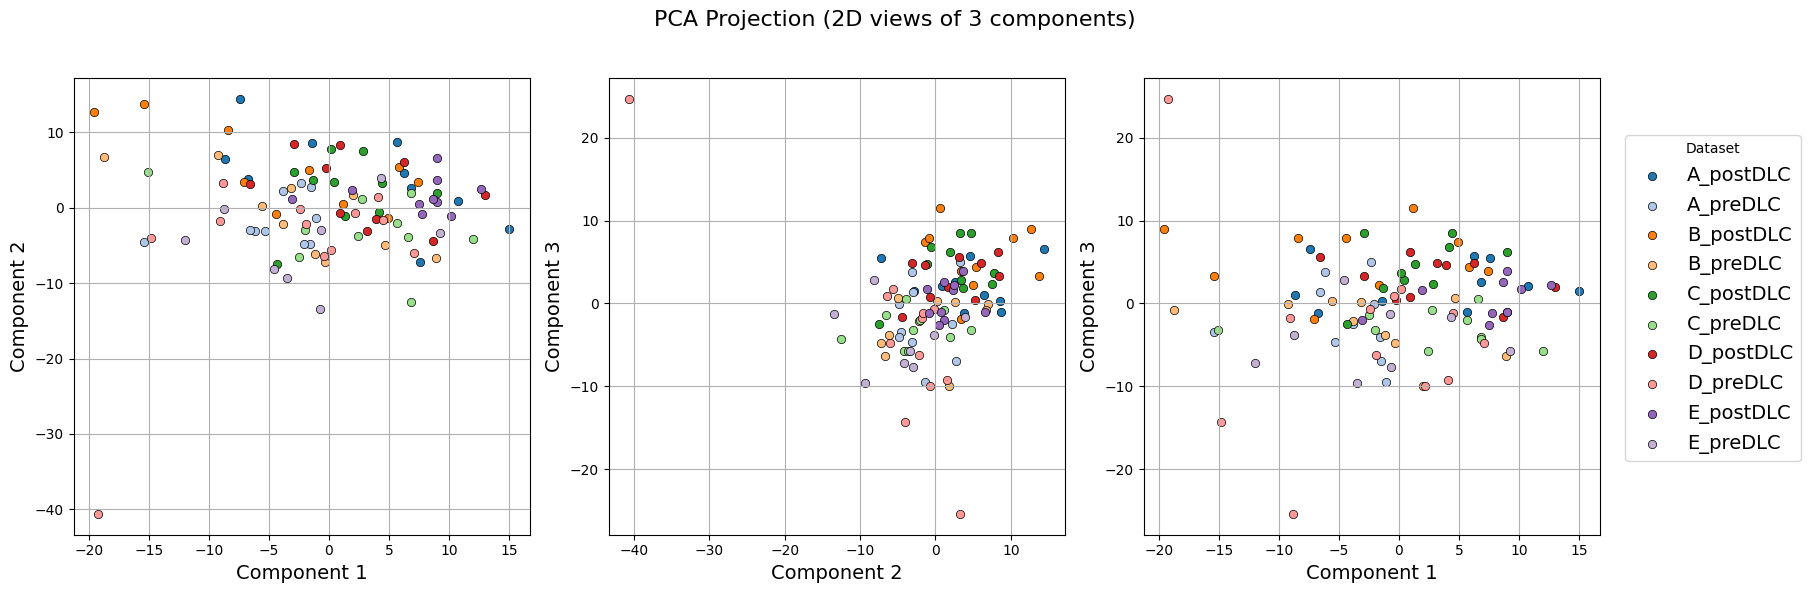

--------------------------------------------------
Top features for PCA1 (Explained Variance: 9.76%):
  • Mean phase value - rhindlimb - ankle (°)_sin, Mean phase during swing - rhindlimb - ankle (°)_sin, Mean phase value - rhindlimb - ankle (°)_cos, Mean phase during swing - rhindlimb - ankle (°)_cos, Mean step velocity X during stance - ankle (m/s), Mean step acceleration Y during stance - lHindfingers (m/s^2), Mean phase during stance - rhindlimb - ankle (°)_sin, Mean phase during stance - rhindlimb - ankle (°)_cos, Mean angle during swing - rhindlimb - lHindfingers (°)_cos, Mean phase during swing - rhindlimb - hip (°)_cos
Top features for PCA2 (Explained Variance: 7.81%):
  • Mean step velocity X at swing - ankle (m/s), Mean step velocity X during swing - ankle (m/s), Mean step velocity X during swing - knee (m/s), Mean step velocity X during swing - lHindpaw (m/s), Mean step velocity X at swing - hip (m/s), Mean step velocity X at swing - lHindpaw (m/s), Mean step velocity X duri

In [150]:
pca_reducer, pca_plot_df = perform_dimensionality_reduction(
    X_agg, y_mouse, y_dataset,
    dataset_label_map, mouse_label_map,
    method="PCA", n_components=3,
    plot=True, save=False
)

In [151]:
features = left_hindlimb_features_df.columns.tolist()

## Convert angle features to radians if they contain '°'
angular_features = [f for f in features if ('angle' in f.lower() or 'phase' in f.lower())
                    and 'excursion' not in f.lower()
                    and not f.lower().endswith('_sin')
                    and not f.lower().endswith('_cos')]
for feature in angular_features:
    if '°' in feature:
        left_hindlimb_features_df[feature] = np.deg2rad(left_hindlimb_features_df[feature])

## Linearize angular features
trig_features = {
    f"{feature}_cos": np.cos(left_hindlimb_features_df[feature]) for feature in angular_features
}
trig_features.update({
    f"{feature}_sin": np.sin(left_hindlimb_features_df[feature]) for feature in angular_features
})
trig_df = pd.DataFrame(trig_features, index=left_hindlimb_features_df.index)
left_hindlimb_features_df = pd.concat([left_hindlimb_features_df.drop(columns=angular_features), trig_df], axis=1)

## Create subsets for left hindlimb
_left_hindlimb_features_df = left_hindlimb_features_df[~left_hindlimb_features_df['Dataset'].str.lower().str.contains('d_')
                                                       & ~left_hindlimb_features_df['Dataset'].str.lower().str.contains('a_')]
healthy_left_hindlimb_features_df = _left_hindlimb_features_df[_left_hindlimb_features_df['Dataset'].str.lower().str.contains('pre')]
sick_left_hindlimb_features_df = _left_hindlimb_features_df[_left_hindlimb_features_df['Dataset'].str.lower().str.contains('post') &
                                                           ~_left_hindlimb_features_df['Dataset'].str.lower().str.contains('e_')]
treatment_left_hindlimb_features_df = _left_hindlimb_features_df[_left_hindlimb_features_df['Dataset'].str.lower().str.contains('post') &
                                                                _left_hindlimb_features_df['Dataset'].str.lower().str.contains('e_')]

print(healthy_left_hindlimb_features_df["Dataset"].unique())
print(sick_left_hindlimb_features_df["Dataset"].unique())
print(treatment_left_hindlimb_features_df["Dataset"].unique())

healthy_left_hindlimb_features_df = healthy_left_hindlimb_features_df.drop(columns=['Dataset', 'Mouse'])
sick_left_hindlimb_features_df = sick_left_hindlimb_features_df.drop(columns=['Dataset', 'Mouse'])
treatment_left_hindlimb_features_df = treatment_left_hindlimb_features_df.drop(columns=['Dataset', 'Mouse'])

print(f"Healthy left hindlimb shape: {healthy_left_hindlimb_features_df.shape}")
print(f"Sick left hindlimb shape: {sick_left_hindlimb_features_df.shape}")
print(f"Treatment left hindlimb shape: {treatment_left_hindlimb_features_df.shape}")

['B_preDLC' 'C_preDLC' 'E_preDLC']
['B_postDLC' 'C_postDLC']
['E_postDLC']
Healthy left hindlimb shape: (28, 571)
Sick left hindlimb shape: (20, 571)
Treatment left hindlimb shape: (10, 571)


In [152]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train Healthy vs Sick model
X = pd.concat([healthy_left_hindlimb_features_df, sick_left_hindlimb_features_df])
y = [0] * len(healthy_left_hindlimb_features_df) + [1] * len(sick_left_hindlimb_features_df)  # 0=Healthy, 1=Sick

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# 2. For each top feature, check treatment direction

number_features = 50

rows = []
for col in importances.index:
    h = healthy_left_hindlimb_features_df[col].dropna()
    s = sick_left_hindlimb_features_df[col].dropna()
    t = treatment_left_hindlimb_features_df[col].dropna()

    if len(h) < 2 or len(s) < 2 or len(t) == 0:
        continue  # skip if no variance or insufficient samples

    d_sick = abs(s.mean() - h.mean())
    d_treat = abs(t.mean() - h.mean())

    # Pooled std for Healthy vs Sick
    pooled_std = np.sqrt(((len(h)-1)*h.var() + (len(s)-1)*s.var()) / (len(h) + len(s) - 2))

    if pooled_std == 0:
        change_effect_size = np.nan
    else:
        change_effect_size = (d_sick - d_treat) / pooled_std

    rows.append((col, importances[col], d_sick - d_treat, change_effect_size))

res_df = pd.DataFrame(rows, columns=["feature", "importance", "change_score", "change_effect_size"])

# Step 3: Sort by combined score
res_df["combined_rank"] = res_df["importance"] * res_df["change_effect_size"].abs()
res_df = res_df.sort_values("combined_rank", ascending=False)

# Optional: add a label for direction
res_df["direction"] = res_df["change_effect_size"].apply(lambda x: "towards_healthy" if x > 0 else "away_from_healthy" if x < 0 else "no_change")

print(res_df.head(20))  # top 20 most important + largest shift
print("\nDirection counts:\n", res_df["direction"].value_counts())

## export results to CSV
res_df.to_csv(os.path.join('./', 'feature_change_analysis_with_at.csv'), index=False)

                                              feature  importance  \
3        Mean angle excursion - rhindlimb - ankle (°)    0.027643   
4   Mean angle at touchdown - rhindlimb - lHindfin...    0.026052   
6   Mean angle at touchdown - rhindlimb - lHindfin...    0.023473   
11  Mean step acceleration Y at touchdown - ankle ...    0.013584   
0     Mean step jerk Y at peak - lHindfingers (m/s^3)    0.050711   
20  Mean angle at stance - rhindlimb - lHindpaw (°...    0.008778   
7     Mean angle value - rhindlimb - lHindpaw (°)_sin    0.017478   
10  Mean step acceleration Y at touchdown - lHindf...    0.015475   
12       Mean phase excursion - rhindlimb - ankle (°)    0.012921   
32  Mean angle at stance - rhindlimb - lHindpaw (°...    0.007106   
22  Mean step acceleration Y during stance - knee ...    0.008710   
8   Mean angle during swing - rhindlimb - lHindpaw...    0.016859   
27  Mean phase at touchdown - rhindlimb - lHindpaw...    0.008113   
9   Mean angle during swing - rhin

In [153]:
fig = px.scatter(
    res_df,
    x="importance",
    y="change_effect_size",
    size="combined_rank",
    color="direction",
    hover_data=["feature", "importance", "change_effect_size", "combined_rank"],
    color_discrete_map={
        "towards_healthy": "green",
        "away_from_healthy": "red",
        "no_change": "gray"
    },
    title="Feature Importance vs. Treatment Direction"
)

fig.add_hline(y=0, line_dash="dash", line_color="black")
fig.show()
# fig.write_html(os.path.join('./', 'treatment_influence.html'))

In [154]:
# 3) Create combined_rank now (so it's available everywhere)
res_df["combined_rank"] = res_df["importance"] * res_df["change_effect_size"].abs()

# 4) Elbow selection on |change_effect_size| (biologically focused)
res_ranked = res_df.copy()
res_ranked = res_ranked.dropna(subset=["change_effect_size"])  # exclude no-gap features from elbow
res_ranked["rank_key"] = res_ranked["change_effect_size"].abs()
res_ranked = res_ranked.sort_values("rank_key", ascending=False).reset_index(drop=True)

if res_ranked.empty:
    k_opt = 0
    selected = res_ranked.copy()
else:
    vals = res_ranked["rank_key"].to_numpy()
    cum = np.cumsum(vals)
    cum_norm = cum / cum[-1]
    x = np.linspace(0, 1, num=len(cum_norm), endpoint=True)
    distances = cum_norm - x
    k_opt = int(np.argmax(distances)) + 1
    selected = res_ranked.iloc[:k_opt].copy()

print(f"Elbow-selected feature count (by |change_effect_size|): {k_opt}")
# print(selected[["feature", "importance", "change_effect_size", "combined_rank"]].head(10))

# 5) Optional biological floor, e.g., at least 20% of gap moved
min_effect = 0.20
selected = selected[selected["change_effect_size"].abs() >= min_effect]
print(f"After enforcing |change_effect_size| ≥ {min_effect:.2f}: {selected.shape[0]} features kept")

# 6) Direction labels (for downstream plots)
res_df["direction"] = np.where(res_df["change_effect_size"] > 0, "towards_healthy",
                        np.where(res_df["change_effect_size"] < 0, "away_from_healthy", "no_change"))

print(res_df.head(20))
print("\nDirection counts:\n", res_df["direction"].value_counts())

# 7) Reduced dataset with selected features
top_feature_list = selected["feature"].tolist()
print(f"Top {len(top_feature_list)} features selected for further analysis.")
_reduced_hindlimb_df = left_hindlimb_features_df[top_feature_list]
print(_reduced_hindlimb_df.shape)
fig = px.scatter(
    res_df[res_df["feature"].isin(top_feature_list)],
    x="importance",
    y="change_effect_size",
    size="combined_rank",
    color="direction",
    hover_data=["feature", "importance", "change_effect_size", "combined_rank"],
    color_discrete_map={
        "towards_healthy": "green",
        "away_from_healthy": "red",
        "no_change": "gray"
    },
    title="Feature Importance vs. Treatment Direction"
)

fig.add_hline(y=0, line_dash="dash", line_color="black")
fig.show()
# fig.write_html(os.path.join('./', 'feature_change_analysis.html'))

Elbow-selected feature count (by |change_effect_size|): 233
After enforcing |change_effect_size| ≥ 0.20: 233 features kept
                                              feature  importance  \
3        Mean angle excursion - rhindlimb - ankle (°)    0.027643   
4   Mean angle at touchdown - rhindlimb - lHindfin...    0.026052   
6   Mean angle at touchdown - rhindlimb - lHindfin...    0.023473   
11  Mean step acceleration Y at touchdown - ankle ...    0.013584   
0     Mean step jerk Y at peak - lHindfingers (m/s^3)    0.050711   
20  Mean angle at stance - rhindlimb - lHindpaw (°...    0.008778   
7     Mean angle value - rhindlimb - lHindpaw (°)_sin    0.017478   
10  Mean step acceleration Y at touchdown - lHindf...    0.015475   
12       Mean phase excursion - rhindlimb - ankle (°)    0.012921   
32  Mean angle at stance - rhindlimb - lHindpaw (°...    0.007106   
22  Mean step acceleration Y during stance - knee ...    0.008710   
8   Mean angle during swing - rhindlimb - lHindpa

In [155]:
# top_feature_list = res_df["feature"].tolist() 
top_feature_list.append('Dataset')
top_feature_list.append('Mouse') 
reduced_hindlimb_df = _left_hindlimb_features_df[top_feature_list]
print(reduced_hindlimb_df.shape)

reduced_features_df = reduced_hindlimb_df[reduced_hindlimb_df['Mouse'].str.lower().str.contains('left')]
preprocessed_data, dataset_label_map, mouse_label_map, label_cols = preprocess_data(reduced_features_df)

X_agg, y_mouse, y_dataset = aggregate_features(preprocessed_data, label_cols, method="median")

umap_reducer, umap_plot_df = perform_dimensionality_reduction(
        X_agg, y_mouse, y_dataset,
        dataset_label_map, mouse_label_map,
        method="UMAP", n_components=3,
        target_metric='categorical',
        target_weight=0,
        n_neighbors=15,
        min_dist=0.05,
        plot=False, save=False
    )

(58, 235)
[DEBUG] Dataset Label Map: {0: 'B_postDLC', 1: 'B_preDLC', 2: 'C_postDLC', 3: 'C_preDLC', 4: 'E_postDLC', 5: 'E_preDLC'}
[DEBUG] Mouse Label Map: {0: 'mouse11_left', 1: 'mouse12_left', 2: 'mouse13_left', 3: 'mouse14_left', 4: 'mouse15_left', 5: 'mouse16_left', 6: 'mouse17_left', 7: 'mouse18_left', 8: 'mouse19_left', 9: 'mouse20_left', 10: 'mouse21_left', 11: 'mouse22_left', 12: 'mouse23_left', 13: 'mouse24_left', 14: 'mouse25_left', 15: 'mouse26_left', 16: 'mouse27_left', 17: 'mouse28_left', 18: 'mouse29_left', 19: 'mouse30_left', 20: 'mouse41_left', 21: 'mouse42_left', 22: 'mouse43_left', 23: 'mouse44_left', 24: 'mouse45_left', 25: 'mouse46_left', 26: 'mouse47_left', 27: 'mouse48_left', 28: 'mouse49_left', 29: 'mouse50_left'}


/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [156]:
### Plotting UMAP in 3D -> 573 features total
umap_plot_df["DatasetName"] = umap_plot_df["Dataset"].map(dataset_label_map)
umap_plot_df["MouseName"]   = umap_plot_df["Mouse"].map(mouse_label_map)

# --- Build a consistent color map ---
fixed_color = "#7f7f7f"  # gray for Pre
all_names = sorted(umap_plot_df["DatasetName"].unique())

# Non-Pre datasets get distinct colors from a qualitative palette
palette = px.colors.qualitative.Plotly  # or px.colors.qualitative.Set3, etc.
non_pre = [n for n in all_names if "pre" not in n.lower()]

color_map = {"Pre": fixed_color}
color_map.update({name: palette[i % len(palette)] for i, name in enumerate(non_pre)})

# Color key: collapse anything containing "pre" to "Pre", keep others as-is
umap_plot_df["ColorKey"] = umap_plot_df["DatasetName"].apply(
    lambda x: "Pre" if "pre" in x.lower() else x
)

# --- Build the two px figures using the SAME color map ---
fig_left = px.scatter_3d(
    umap_plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="ColorKey",
    hover_name="MouseName",
    hover_data={"Dataset": True, "Mouse": True},
    title="UMAP 3D — Pre vs Others",
    color_discrete_map=color_map
)
fig_left.update_traces(marker=dict(size=4, line=dict(width=0.3, color='black')),
                       selector=dict(mode='markers'))

fig_right = px.scatter_3d(
    umap_plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="DatasetName",
    hover_name="MouseName",
    hover_data={"Dataset": True, "Mouse": True},
    title="UMAP 3D — Each Dataset",
    color_discrete_map=color_map
)
fig_right.update_traces(marker=dict(size=4, line=dict(width=0.3, color='black')),
                        selector=dict(mode='markers'))

# --- Put them side by side with shared legend ---
combo = make_subplots(rows=1, cols=2,
                      specs=[[{"type": "scene"}, {"type": "scene"}]],
                      subplot_titles=(fig_left.layout.title.text, fig_right.layout.title.text))

for tr in fig_left.data:
    combo.add_trace(tr, row=1, col=1)
for tr in fig_right.data:
    combo.add_trace(tr, row=1, col=2)

# Layout tweaks: one legend, equal aspect, tidy margins
combo.update_layout(
    showlegend=True,
    legend=dict(title="Dataset", orientation="v"),
    scene=dict(aspectmode="data"),
    scene2=dict(aspectmode="data"),
    margin=dict(l=0, r=0, t=60, b=0),
    height=600, width=1100
)

combo.show()
combo.write_html(os.path.join('./', 'umap_reduced_features_with_at.html'))

In [157]:
### Test with no "at" features
# 1. Train Healthy vs Sick model

## remove features with ' at ' in the name
_healthy_left_hindlimb_features_df = healthy_left_hindlimb_features_df.loc[
    :, ~healthy_left_hindlimb_features_df.columns.str.contains(' at ')
]
_sick_left_hindlimb_features_df = sick_left_hindlimb_features_df.loc[
    :, ~sick_left_hindlimb_features_df.columns.str.contains(' at ')
]
_treatment_left_hindlimb_features_df = treatment_left_hindlimb_features_df.loc[
    :, ~treatment_left_hindlimb_features_df.columns.str.contains(' at ')
]

X = pd.concat([_healthy_left_hindlimb_features_df, _sick_left_hindlimb_features_df])
y = [0] * len(_healthy_left_hindlimb_features_df) + [1] * len(_sick_left_hindlimb_features_df)  # 0=Healthy, 1=Sick

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# 2. For each top feature, check treatment direction
rows = []
for col in importances.index:
    h = _healthy_left_hindlimb_features_df[col].dropna()
    s = _sick_left_hindlimb_features_df[col].dropna()
    t = _treatment_left_hindlimb_features_df[col].dropna()

    if len(h) < 2 or len(s) < 2 or len(t) == 0:
        continue  # skip if no variance or insufficient samples

    d_sick = abs(s.mean() - h.mean())
    d_treat = abs(t.mean() - h.mean())

    # Pooled std for Healthy vs Sick
    pooled_std = np.sqrt(((len(h)-1)*h.var() + (len(s)-1)*s.var()) / (len(h) + len(s) - 2))

    if pooled_std == 0:
        change_effect_size = np.nan
    else:
        change_effect_size = (d_sick - d_treat) / pooled_std

    rows.append((col, importances[col], d_sick - d_treat, change_effect_size))

res_df = pd.DataFrame(rows, columns=["feature", "importance", "change_score", "change_effect_size"])

# Step 3: Sort by combined score
res_df["combined_rank"] = res_df["importance"] * res_df["change_effect_size"].abs()
res_df = res_df.sort_values("combined_rank", ascending=False)

# Optional: add a label for direction
res_df["direction"] = res_df["change_effect_size"].apply(lambda x: "towards_healthy" if x > 0 else "away_from_healthy" if x < 0 else "no_change")

# print(res_df.head(20))  # top 20 most important + largest shift
print("Feature number after removing ' at ': ", res_df.shape[0])
print("\nDirection counts:\n", res_df["direction"].value_counts())

## export results to CSV
res_df.to_csv(os.path.join('./', 'feature_change_analysis_no_at.csv'), index=False)

fig = px.scatter(
    res_df,
    x="importance",
    y="change_effect_size",
    size="combined_rank",
    color="direction",
    hover_data=["feature", "importance", "change_effect_size", "combined_rank"],
    color_discrete_map={
        "towards_healthy": "green",
        "away_from_healthy": "red",
        "no_change": "gray"
    },
    title="Feature Importance vs. Treatment Direction"
)

fig.add_hline(y=0, line_dash="dash", line_color="black")
fig.show()
# fig.write_html(os.path.join('./', 'treatment_influence.html'))

print(res_df.head(20))

Feature number after removing ' at ':  235

Direction counts:
 direction
away_from_healthy    137
towards_healthy       98
Name: count, dtype: int64


                                              feature  importance  \
0        Mean angle excursion - rhindlimb - ankle (°)    0.057061   
1   Mean angle during swing - rhindlimb - lHindpaw...    0.053810   
3     Mean angle value - rhindlimb - lHindpaw (°)_cos    0.031388   
4        Mean phase excursion - rhindlimb - ankle (°)    0.029125   
2   Mean angle during swing - rhindlimb - lHindpaw...    0.046290   
5     Mean angle value - rhindlimb - lHindpaw (°)_sin    0.027937   
6   Mean angle during stance - rhindlimb - lHindpa...    0.024847   
12  Mean angle velocity - rhindlimb - knee (rad/s)...    0.019240   
9   Mean angle during stance - rhindlimb - lHindpa...    0.020477   
7   Mean step acceleration X during stance - ankle...    0.023246   
15  Mean step acceleration Y during stance - knee ...    0.012819   
11  Mean angle velocity - rhindlimb - knee (rad/s)...    0.019311   
17  Mean step velocity Y during stance - lHindpaw ...    0.010543   
8   Mean step acceleration X durin

In [158]:
# 3) Create combined_rank now (so it's available everywhere)
res_df["combined_rank"] = res_df["importance"] * res_df["change_effect_size"].abs()

# 4) Elbow selection on |change_effect_size| (biologically focused)
res_ranked = res_df.copy()
res_ranked = res_ranked.dropna(subset=["change_effect_size"])  # exclude no-gap features from elbow
res_ranked["rank_key"] = res_ranked["change_effect_size"].abs()
res_ranked = res_ranked.sort_values("rank_key", ascending=False).reset_index(drop=True)

if res_ranked.empty:
    k_opt = 0
    selected = res_ranked.copy()
else:
    vals = res_ranked["rank_key"].to_numpy()
    cum = np.cumsum(vals)
    cum_norm = cum / cum[-1]
    x = np.linspace(0, 1, num=len(cum_norm), endpoint=True)
    distances = cum_norm - x
    k_opt = int(np.argmax(distances)) + 1
    selected = res_ranked.iloc[:k_opt].copy()

print(f"Elbow-selected feature count (by |change_effect_size|): {k_opt}")
# print(selected[["feature", "importance", "change_effect_size", "combined_rank"]].head(10))

# 5) Optional biological floor, e.g., at least 20% of gap moved
min_effect = 0.20
selected = selected[selected["change_effect_size"].abs() >= min_effect]
print(f"After enforcing |change_effect_size| ≥ {min_effect:.2f}: {selected.shape[0]} features kept")

# 6) Direction labels (for downstream plots)
res_df["direction"] = np.where(res_df["change_effect_size"] > 0, "towards_healthy",
                        np.where(res_df["change_effect_size"] < 0, "away_from_healthy", "no_change"))

print(res_df.head(20))
print("\nDirection counts:\n", res_df["direction"].value_counts())

# 7) Reduced dataset with selected features
top_feature_list = selected["feature"].tolist()
print(f"Top {len(top_feature_list)} features selected for further analysis.")
_reduced_hindlimb_df = left_hindlimb_features_df[top_feature_list]
print(_reduced_hindlimb_df.shape)
fig = px.scatter(
    res_df[res_df["feature"].isin(top_feature_list)],
    x="importance",
    y="change_effect_size",
    size="combined_rank",
    color="direction",
    hover_data=["feature", "importance", "change_effect_size", "combined_rank"],
    color_discrete_map={
        "towards_healthy": "green",
        "away_from_healthy": "red",
        "no_change": "gray"
    },
    title="Feature Importance vs. Treatment Direction"
)

fig.add_hline(y=0, line_dash="dash", line_color="black")
# fig.show()
# fig.write_html(os.path.join('./', 'feature_change_analysis.html'))

Elbow-selected feature count (by |change_effect_size|): 97
After enforcing |change_effect_size| ≥ 0.20: 97 features kept
                                              feature  importance  \
0        Mean angle excursion - rhindlimb - ankle (°)    0.057061   
1   Mean angle during swing - rhindlimb - lHindpaw...    0.053810   
3     Mean angle value - rhindlimb - lHindpaw (°)_cos    0.031388   
4        Mean phase excursion - rhindlimb - ankle (°)    0.029125   
2   Mean angle during swing - rhindlimb - lHindpaw...    0.046290   
5     Mean angle value - rhindlimb - lHindpaw (°)_sin    0.027937   
6   Mean angle during stance - rhindlimb - lHindpa...    0.024847   
12  Mean angle velocity - rhindlimb - knee (rad/s)...    0.019240   
9   Mean angle during stance - rhindlimb - lHindpa...    0.020477   
7   Mean step acceleration X during stance - ankle...    0.023246   
15  Mean step acceleration Y during stance - knee ...    0.012819   
11  Mean angle velocity - rhindlimb - knee (rad/s).

In [159]:
## Check which features in the feature list are significant in the original analysis
data = comparison_results[limb]

# print(top_feature_list)

# print(data[0][1]['significant_features'][0])

top_feature_set = set(top_feature_list)  # O(1) lookups

def filter_sig(sig_tuples, keep_names):
    """
    sig_tuples: list[tuple[str, str, str]]
    keep_names: set[str]
    returns:
      - filtered tuples whose feature name is in keep_names
      - and just the names (if you want names only)
    """
    filtered = [t for t in sig_tuples if t[0] in keep_names]
    names = [t[0] for t in filtered]
    return filtered, names

def process_comparison(key1, key2, result, group_label, match_fn, top_features, res_df):
    """
    key1, key2: str from comparison_results
    result: dict containing 'significant_features' and 'n_significant'
    group_label: str, label for printing
    match_fn: function that takes (k1, k2) and returns True if we should process
    top_features: set of feature names to intersect with
    """
    k1, k2 = key1.lower(), key2.lower()
    if not match_fn(k1, k2):
        return

    sig = result.get("significant_features", [])
    feats, names = filter_sig(sig, top_features)

    dir_map = dict(zip(res_df["feature"], res_df["direction"]))
    names_with_dir = [(name, dir_map.get(name, "unknown")) for name in names]
    
    print(f"Comparison {key1} vs {key2}:")
    print(f"\tNumber of significant features: {result.get('n_significant', 0)}")
    print(f"\tNumber of significant features by {group_label}: {len(feats)}")
    print(f"\tSignificant features by {group_label}: {names_with_dir}")
    print("-" * 40)

    return feats, names


# --- Conditions as small reusable lambdas ---
conditions = [
    # ("A", lambda k1, k2: "a_" in k1 and "e_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2),
    # ("B", lambda k1, k2: "b_" in k1 and "e_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2),
    # ("C", lambda k1, k2: "c_" in k1 and "e_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2),
    # ("All", lambda k1, k2: "all_" in k1 and "e_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2),
    # ("C (lesion effect)", lambda k1, k2: "c_" in k1 and "c_" in k2 and (
    #     ("healthy" in k1 and "sick" in k2) or ("healthy" in k2 and "sick" in k1)
    # ) and "left" in k1 and "left" in k2),
    # ("Healthy vs C", lambda k1, k2: "all_" in k1 and "c_" in k2 and "sick" in k2 and "left" in k1 and "left" in k2),
    ("Lesion effect", lambda k1, k2: "all_" in k1 and "healthy" in k1 and "c_" in k2 and "sick" in k2 and "left" in k1 and "left" in k2),
    ("Treatment effect", lambda k1, k2: "c_" in k1 and "e_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2),
    ("All vs E", lambda k1, k2: "all_" in k1 and "e_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2),
    ("C vs B", lambda k1, k2: "c_" in k1 and "b_" in k2 and "sick" in k1 and "sick" in k2 and "left" in k1 and "left" in k2)
]

name_dict = {label: [] for label, _ in conditions}
for (key1, key2), result in comparison_results[limb]:
    for label, match_fn in conditions:
        out = process_comparison(key1, key2, result, label, match_fn, top_feature_set, res_df)
        if out is not None:
            _, names = out
            name_dict[label].extend(names)

Comparison sick_left_C_run vs sick_left_E_run:
	Number of significant features: 50
	Number of significant features by Treatment effect: 4
	Significant features by Treatment effect: [('Mean step acceleration Y during swing - lHindfingers (m/s^2)', 'towards_healthy'), ('Mean step jerk Y during swing - lHindpaw (m/s^3)', 'away_from_healthy'), ('Mean step velocity X during stance - ankle (m/s)', 'away_from_healthy'), ('Mean step velocity X during swing - hip (m/s)', 'towards_healthy')]
----------------------------------------
Comparison sick_left_ALL_run vs sick_left_E_run:
	Number of significant features: 133
	Number of significant features by All vs E: 21
	Significant features by All vs E: [('Mean angle excursion - rhindlimb - ankle (°)', 'away_from_healthy'), ('Mean angle excursion - rhindlimb - lHindfingers (°)', 'away_from_healthy'), ('Mean phase excursion - rhindlimb - ankle (°)', 'away_from_healthy'), ('Mean phase excursion - rhindlimb - lHindpaw (°)', 'away_from_healthy'), ('Mean s

In [160]:
# top_feature_list = res_df["feature"].tolist() 
top_feature_list.append('Dataset')
top_feature_list.append('Mouse') 
reduced_hindlimb_df = _left_hindlimb_features_df[top_feature_list]
print(reduced_hindlimb_df.shape)

reduced_features_df = reduced_hindlimb_df[reduced_hindlimb_df['Mouse'].str.lower().str.contains('left')]
preprocessed_data, dataset_label_map, mouse_label_map, label_cols = preprocess_data(reduced_features_df)

X_agg, y_mouse, y_dataset = aggregate_features(preprocessed_data, label_cols, method="median")

umap_reducer, umap_plot_df = perform_dimensionality_reduction(
        X_agg, y_mouse, y_dataset,
        dataset_label_map, mouse_label_map,
        method="UMAP", n_components=3,
        target_metric='categorical',
        target_weight=0,
        n_neighbors=15,
        min_dist=0.05,
        plot=False, save=False
    )

(58, 99)
[DEBUG] Dataset Label Map: {0: 'B_postDLC', 1: 'B_preDLC', 2: 'C_postDLC', 3: 'C_preDLC', 4: 'E_postDLC', 5: 'E_preDLC'}
[DEBUG] Mouse Label Map: {0: 'mouse11_left', 1: 'mouse12_left', 2: 'mouse13_left', 3: 'mouse14_left', 4: 'mouse15_left', 5: 'mouse16_left', 6: 'mouse17_left', 7: 'mouse18_left', 8: 'mouse19_left', 9: 'mouse20_left', 10: 'mouse21_left', 11: 'mouse22_left', 12: 'mouse23_left', 13: 'mouse24_left', 14: 'mouse25_left', 15: 'mouse26_left', 16: 'mouse27_left', 17: 'mouse28_left', 18: 'mouse29_left', 19: 'mouse30_left', 20: 'mouse41_left', 21: 'mouse42_left', 22: 'mouse43_left', 23: 'mouse44_left', 24: 'mouse45_left', 25: 'mouse46_left', 26: 'mouse47_left', 27: 'mouse48_left', 28: 'mouse49_left', 29: 'mouse50_left'}


/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/filthyweeb/Documents/SeriousStuff/Work/KU/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [161]:
### Plotting UMAP in 3D -> 573 features total
umap_plot_df["DatasetName"] = umap_plot_df["Dataset"].map(dataset_label_map)
umap_plot_df["MouseName"]   = umap_plot_df["Mouse"].map(mouse_label_map)

# --- Build a consistent color map ---
fixed_color = "#7f7f7f"  # gray for Pre
all_names = sorted(umap_plot_df["DatasetName"].unique())

# Non-Pre datasets get distinct colors from a qualitative palette
palette = px.colors.qualitative.Plotly  # or px.colors.qualitative.Set3, etc.
non_pre = [n for n in all_names if "pre" not in n.lower()]

color_map = {"Pre": fixed_color}
color_map.update({name: palette[i % len(palette)] for i, name in enumerate(non_pre)})

# Color key: collapse anything containing "pre" to "Pre", keep others as-is
umap_plot_df["ColorKey"] = umap_plot_df["DatasetName"].apply(
    lambda x: "Pre" if "pre" in x.lower() else x
)

# --- Build the two px figures using the SAME color map ---
fig_left = px.scatter_3d(
    umap_plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="ColorKey",
    hover_name="MouseName",
    hover_data={"Dataset": True, "Mouse": True},
    title="UMAP 3D — Pre vs Others",
    color_discrete_map=color_map
)
fig_left.update_traces(marker=dict(size=4, line=dict(width=0.3, color='black')),
                       selector=dict(mode='markers'))

fig_right = px.scatter_3d(
    umap_plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="DatasetName",
    hover_name="MouseName",
    hover_data={"Dataset": True, "Mouse": True},
    title="UMAP 3D — Each Dataset",
    color_discrete_map=color_map
)
fig_right.update_traces(marker=dict(size=4, line=dict(width=0.3, color='black')),
                        selector=dict(mode='markers'))

# --- Put them side by side with shared legend ---
combo = make_subplots(rows=1, cols=2,
                      specs=[[{"type": "scene"}, {"type": "scene"}]],
                      subplot_titles=(fig_left.layout.title.text, fig_right.layout.title.text))

for tr in fig_left.data:
    combo.add_trace(tr, row=1, col=1)
for tr in fig_right.data:
    combo.add_trace(tr, row=1, col=2)

# Layout tweaks: one legend, equal aspect, tidy margins
combo.update_layout(
    showlegend=True,
    legend=dict(title="Dataset", orientation="v"),
    scene=dict(aspectmode="data"),
    scene2=dict(aspectmode="data"),
    margin=dict(l=0, r=0, t=60, b=0),
    height=600, width=1100
)

combo.show()
combo.write_html(os.path.join('./', 'umap_reduced_features_no_at.html'))

In [193]:
def plot_features_list_across_groups(feature_list, feature_subsets, limb='hindlimb', 
                                     max_cols=4, groups=['A_', 'B_', 'C_', 'D_', 'E_'], 
                                     states=['healthy', 'sick'], sides=['left', 'right']):
    """
    Plot a given list of exact feature names across all groups for a given limb.
    """
    data_subsets = feature_subsets[limb]
    matched_features = [f for f in feature_list if any(f in df.columns for df in data_subsets.values())]

    if not matched_features:
        print("No matching features found in the data.")
        return
    
    if 'ALL_' in groups:
        # Merge the relevant sick groups (excluding D and E)
        all_sick = pd.concat([
            feature_subsets[limb]['sick_left_B_run'],
            feature_subsets[limb]['sick_left_C_run']
        ], ignore_index=True)
        all_healthy = pd.concat([
            feature_subsets[limb]['healthy_left_E_run'],
            feature_subsets[limb]['healthy_left_B_run'],
            feature_subsets[limb]['healthy_left_C_run']
        ], ignore_index=True)
        feature_subsets[limb]['sick_left_ALL_run'] = all_sick
        feature_subsets[limb]['healthy_left_ALL_run'] = all_healthy

    num_features = len(matched_features)
    rows = (num_features + max_cols - 1) // max_cols
    cols = min(num_features, max_cols)

    palette = px.colors.qualitative.Plotly
    subplot_titles = [
        f.replace('Mean', '').replace('- rhindlimb - ', '').strip()
        for f in matched_features
    ]

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

    for idx, feature in enumerate(matched_features):
        row = idx // max_cols + 1
        col = idx % max_cols + 1

        group_means, group_stds, group_names, group_points = [], [], [], []

        for name, df in data_subsets.items():
            if feature not in df.columns:
                continue
            if not any(side in name.lower() for side in sides):
                continue
            if not (any(g in name for g in groups) and any(s in name for s in states)):
                continue

            values = df[feature].dropna()
            if len(values) == 0:
                continue

            group_means.append(values.mean())
            group_stds.append(values.std())
            group_names.append(name)
            group_points.append(values)

        if not group_names:
            continue

        bar_colors = [palette[i % len(palette)] for i in range(len(group_names))]

        # Bar with error bars
        fig.add_trace(
            go.Bar(
                x=group_names,
                y=group_means,
                error_y=dict(type='data', array=group_stds, visible=True),
                name=feature,
                marker=dict(
                    color=bar_colors,
                    line=dict(color='black', width=1)
                )
            ),
            row=row, col=col
        )

        # Scatter points
        for i, (group, values) in enumerate(zip(group_names, group_points)):
            fig.add_trace(
                go.Scatter(
                    x=[group] * len(values),
                    y=values,
                    mode='markers',
                    marker=dict(size=6, opacity=0.5, color='black'),
                    showlegend=False
                ),
                row=row, col=col
            )

    fig.update_layout(
        title="Selected Features Across Groups",
        showlegend=False,
        height=500 * rows,
        width=400 * cols,
        plot_bgcolor='rgba(0,0,0,0)'
    )
    return fig

In [204]:
## Compare the statistically significant results against the e_sick group
print(f"Number of features: {len(res_df)}")

## remove all the features in all_vs_c_df that have ' at ' in the name
all_vs_c_df = all_vs_c_df[~all_vs_c_df['feature'].str.contains(' at ', case=False)]
print(f"Number of significant features that describe the lesion effect: {len(all_vs_c_df)}")

res_df_lesion = res_df[res_df['feature'].isin(all_vs_c_df['feature'])]

print(f"Number selected lesion features affected by the treatment: {len(res_df_lesion)}")
print(f"Lesion features affected by the treatment:\n{res_df_lesion.head()}")
print(f"Number of features going towards healthy: {len(res_df_lesion[res_df_lesion['direction'] == 'towards_healthy'])}")
print(res_df_lesion['feature'][res_df_lesion['direction'] == 'towards_healthy'].to_list())
print(f"Number of features worsening: {len(res_df_lesion[res_df_lesion['direction'] == 'away_from_healthy'])}")
print(res_df_lesion['feature'][res_df_lesion['direction'] == 'away_from_healthy'].to_list())

## Compare all healthy vs treatment to see non-pathology-related features
healthy_vs_treatment_df = all_vs_e_df[~all_vs_e_df['feature'].str.contains(' at ', case=False)]
print(f"\nNumber of significant features affected by the treatment: {len(healthy_vs_treatment_df)}")
## Remove the features that are in the lesion effect
healthy_vs_treatment_df = healthy_vs_treatment_df[~healthy_vs_treatment_df['feature'].isin(all_vs_c_df['feature'])]

res_df_treatment = res_df[res_df['feature'].isin(healthy_vs_treatment_df['feature'])]
print(f"Number of selected features that are not pathological: {len(res_df_treatment)}")

print(f"Non-pathological features: {res_df_treatment.head()}")
print(f"Number of features going towards healthy: {len(res_df_treatment[res_df_treatment['direction'] == 'towards_healthy'])}")
print(res_df_treatment['feature'][res_df_treatment['direction'] == 'towards_healthy'].to_list())
print(f"Number of features worsening: {len(res_df_treatment[res_df_treatment['direction'] == 'away_from_healthy'])}")
print(res_df_treatment['feature'][res_df_treatment['direction'] == 'away_from_healthy'].to_list())

### DEBUG
# lesion_set = set(all_vs_c_df['feature'])
# treat_set = set(healthy_vs_treatment_df['feature'])

# overlap = lesion_set & treat_set

# print(f"Lesion features: {len(lesion_set)}")
# print(f"Treatment features: {len(treat_set)}")
# print(f"Overlap: {len(overlap)}")
# print(f"Expected non-pathological: {len(treat_set) - len(overlap)}")
# print(f"Your non-pathological: {len(healthy_vs_treatment_df[~healthy_vs_treatment_df['feature'].isin(lesion_set)])}")
res_df_lesion.to_csv(os.path.join('./', 'lesion_features_affected_by_treatment.csv'), index=False)
res_df_treatment.to_csv(os.path.join('./', 'non_pathological_features_affected_by_treatment.csv'), index=False)

print(feature_subsets[limb].keys())
fig_lesion = plot_features_list_across_groups(
    feature_list=res_df_lesion['feature'].tolist(),
    feature_subsets=feature_subsets,
    limb='hindlimb',
    sides=['left'],  # or ['left', 'right']
    groups=['healthy_left_ALL_', 'sick_left_C_']  
)
fig_lesion.show()

fig_non_path = plot_features_list_across_groups(
    feature_list=res_df_treatment['feature'].tolist(),
    feature_subsets=feature_subsets,
    limb='hindlimb',
    sides=['left'],
    groups=['healthy_left_ALL_', 'sick_left_E_'] 
)
fig_non_path.show()

fig_lesion.write_image("lesion_features.svg")
fig_non_path.write_image("non_pathological_features.svg")

Number of features: 235
Number of significant features that describe the lesion effect: 36
Number selected lesion features affected by the treatment: 14
Lesion features affected by the treatment:
                                              feature  importance  \
0        Mean angle excursion - rhindlimb - ankle (°)    0.057061   
4        Mean phase excursion - rhindlimb - ankle (°)    0.029125   
7   Mean step acceleration X during stance - ankle...    0.023246   
17  Mean step velocity Y during stance - lHindpaw ...    0.010543   
8   Mean step acceleration X during stance - lHind...    0.020669   

    change_score  change_effect_size  combined_rank          direction  
0      -7.819830           -0.895282       0.051085  away_from_healthy  
4      -6.268268           -0.812637       0.023668  away_from_healthy  
7       0.270241            0.570418       0.013260    towards_healthy  
17      0.005243            0.939606       0.009906    towards_healthy  
8       0.231552        